### Business Context

You are analyzing transactional data from a global supplier. The goal is to evaluate revenue performance, customer concentration, shipping efficiency, and supplier contribution across regions.


### Objectives:
- Analyze revenue trends over time

- Identify top revenue-driving customers

- Evaluate shipping performance

- Quantify financial impact of delivery delays

- Rank suppliers by regional performance

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

conn = sqlite3.connect("TPC-H-DB.db")

# Show all tables in the database
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)

conn.close()


       name
0    NATION
1    REGION
2      PART
3  SUPPLIER
4  PARTSUPP
5  CUSTOMER
6    ORDERS
7  LINEITEM


In [2]:
def test(db_path, sql_query):
    """
    Connects to SQLite database, runs a SQL query, and returns the results as a DataFrame.
    
    Args:
        db_path (str): Path to the SQLite .db file.
        sql_query (str): SQL query string to execute.
        
    Returns:
        pd.DataFrame: Query results.
    """
    try:
        conn = sqlite3.connect(db_path)
        df = pd.read_sql(sql_query, conn)
        conn.close()
        return df
    except Exception as e:
        print(f"Error running query: {e}")
        return None

# Example usage:
if __name__ == "__main__":
    db_file = "TPC-H-DB.db"
    query = "SELECT COUNT(*) AS order_count FROM orders;"
    result_df = test(db_file, query)
    print(result_df)


   order_count
0        15000


In [3]:
def run_sql_query(db_path, sql_query):
    conn = sqlite3.connect(db_path)
    df = pd.read_sql(sql_query, conn)
    conn.close()
    return df

db_file = "TPC-H-DB.db"


# Total revenue for each year

/var/folders/1m/lj3knm290l95p0fsr7jzt02c0000gn/T/ipykernel_1450/125582689.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="year", y="total_revenue", data=revenue_df, palette="Blues_d")


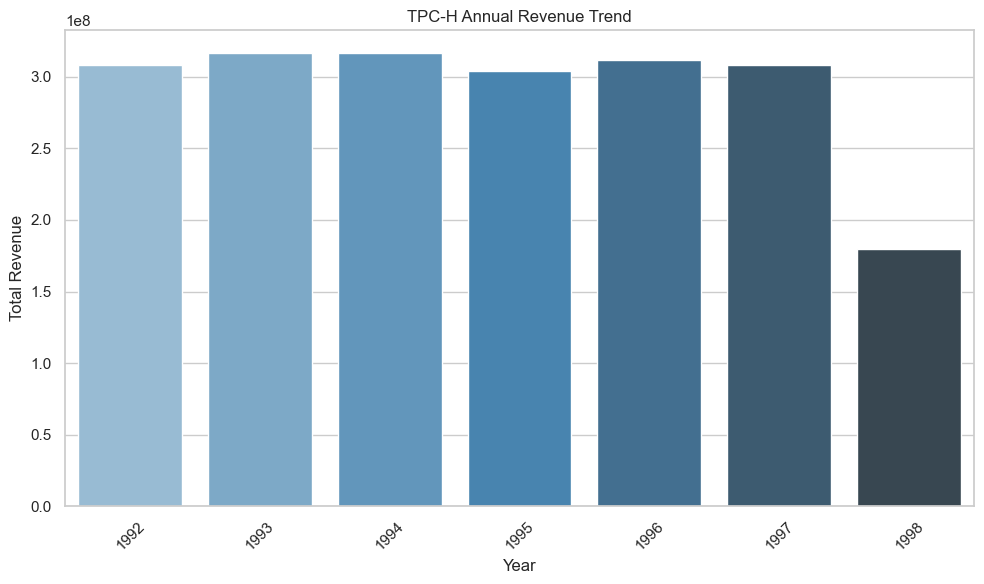

In [9]:
# SQL query for annual revenue
query = """
SELECT
    substr(o_orderdate, 1, 4) AS year,
    ROUND(SUM(l_extendedprice * (1 - l_discount)), 2) AS total_revenue
FROM
    orders
JOIN
    lineitem ON orders.o_orderkey = lineitem.l_orderkey
GROUP BY
    year
ORDER BY
    year;
"""


revenue_df = run_sql_query(db_file, query)

# Save for further analysis in excel and bi
revenue_df.to_csv("annual_revenue.csv", index=False)

# Visualize
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x="year", y="total_revenue", data=revenue_df, palette="Blues_d")
plt.title("TPC-H Annual Revenue Trend")
plt.xlabel("Year")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Revenue shows consistent growth from 1992 through 1997, followed by a sharp decline in 1998.

#### Possible Explanations

- Partial Year Data:
TPC-H data often contains incomplete final-year records depending on how it was generated. If 1998 contains only part of the year, the dip may not reflect actual business decline.

- Order Volume Reduction:
The decline could be driven by fewer total orders in 1998.

- Large Customer Drop-Off:
High-value customers may have reduced purchasing volume.

# Identify the top 10 spenders

Index(['C_CUSTKEY', 'C_NAME', 'total_spent'], dtype='object')
   C_CUSTKEY              C_NAME  total_spent
0       1489  Customer#000001489   5203674.05
1        214  Customer#000000214   4503703.90
2         73  Customer#000000073   4466381.05
3       1246  Customer#000001246   4465335.62
4       1396  Customer#000001396   4455381.82


/var/folders/1m/lj3knm290l95p0fsr7jzt02c0000gn/T/ipykernel_1450/586036077.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


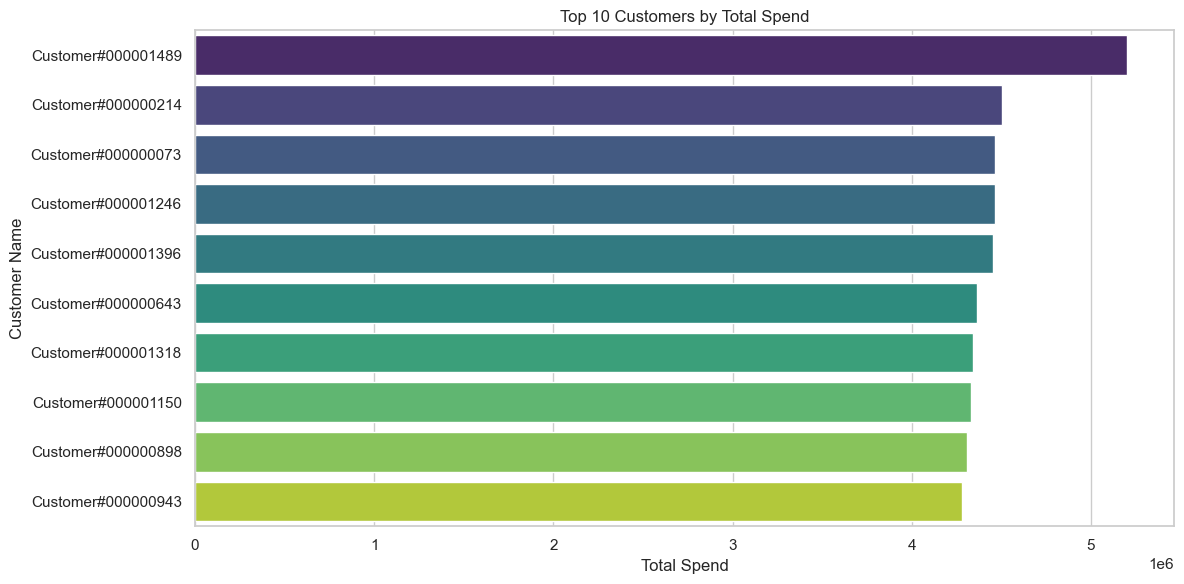

In [10]:
query = """
SELECT
    c_custkey,
    c_name,
    ROUND(SUM(l_extendedprice * (1 - l_discount)), 2) AS total_spent
FROM
    customer c
JOIN
    orders o ON c.c_custkey = o.o_custkey
JOIN
    lineitem l ON o.o_orderkey = l.l_orderkey
GROUP BY
    c_custkey, c_name
ORDER BY
    total_spent DESC
LIMIT 10;
"""


top_customers_df = run_sql_query(db_file, query)

# Save for further analysis in excel and bi
top_customers_df.to_csv("top_customers.csv", index=False)


print(top_customers_df.columns)
print(top_customers_df.head())
# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(
    x="total_spent",
    y="C_NAME",
    data=top_customers_df,
    palette="viridis"
)
plt.title("Top 10 Customers by Total Spend")
plt.xlabel("Total Spend")
plt.ylabel("Customer Name")
plt.tight_layout()
plt.show()


### We see that there is 1 customer, Customer#000001489 who spent significantly more than other clients. Additionally, spending is heavily concentrated among the top 10 customers indicating concentration risk

# Find the most frequently used shipping methods and how much revenue is associated with each.

/var/folders/1m/lj3knm290l95p0fsr7jzt02c0000gn/T/ipykernel_1450/2848746719.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="ship_mode", y="shipment_count", data=shipmode_df, palette="Set2")


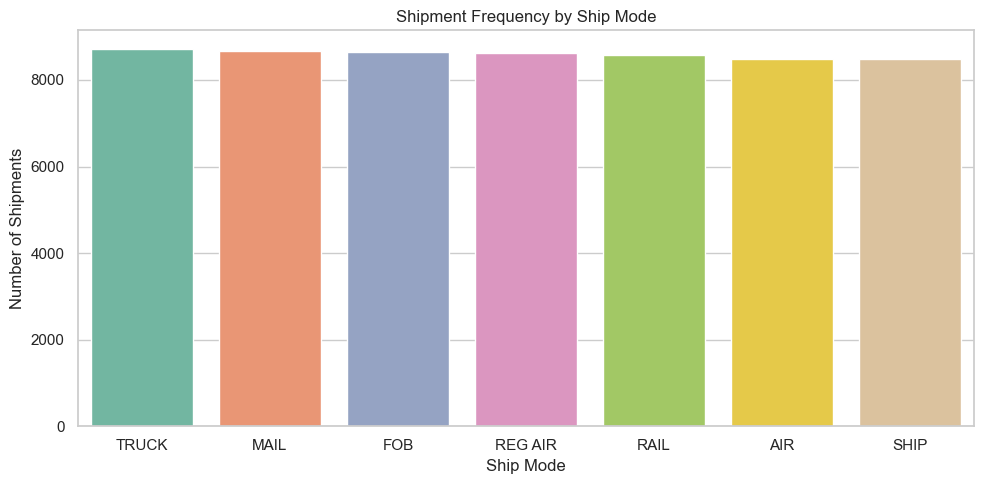

/var/folders/1m/lj3knm290l95p0fsr7jzt02c0000gn/T/ipykernel_1450/2848746719.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="ship_mode", y="total_revenue", data=shipmode_df, palette="Set1")


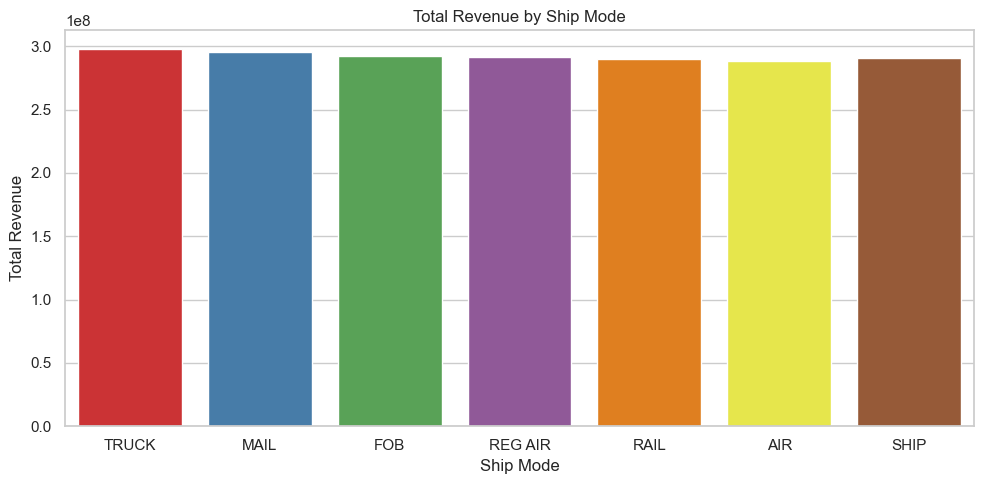

In [11]:

query = """
SELECT
    l_shipmode AS ship_mode,
    COUNT(*) AS shipment_count,
    ROUND(SUM(l_extendedprice * (1 - l_discount)), 2) AS total_revenue
FROM
    lineitem
GROUP BY
    l_shipmode
ORDER BY
    shipment_count DESC;
"""

shipmode_df = run_sql_query(db_file, query)

# Save for further analysis in excel and bi
shipmode_df.to_csv("shipmode_analysis.csv", index=False)

# Plot shipment count
plt.figure(figsize=(10, 5))
sns.barplot(x="ship_mode", y="shipment_count", data=shipmode_df, palette="Set2")
plt.title("Shipment Frequency by Ship Mode")
plt.xlabel("Ship Mode")
plt.ylabel("Number of Shipments")
plt.tight_layout()
plt.show()

# Plot total revenue by ship mode
plt.figure(figsize=(10, 5))
sns.barplot(x="ship_mode", y="total_revenue", data=shipmode_df, palette="Set1")
plt.title("Total Revenue by Ship Mode")
plt.xlabel("Ship Mode")
plt.ylabel("Total Revenue")
plt.tight_layout()
plt.show()


### In general, all delivery methods have similar revenue earned 

# Measure how late deliveries are on average (in days), and compare across different l_shipmode.


/var/folders/1m/lj3knm290l95p0fsr7jzt02c0000gn/T/ipykernel_1450/4050562097.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="ship_mode", y="avg_delay_days", data=delay_df, palette="Oranges")


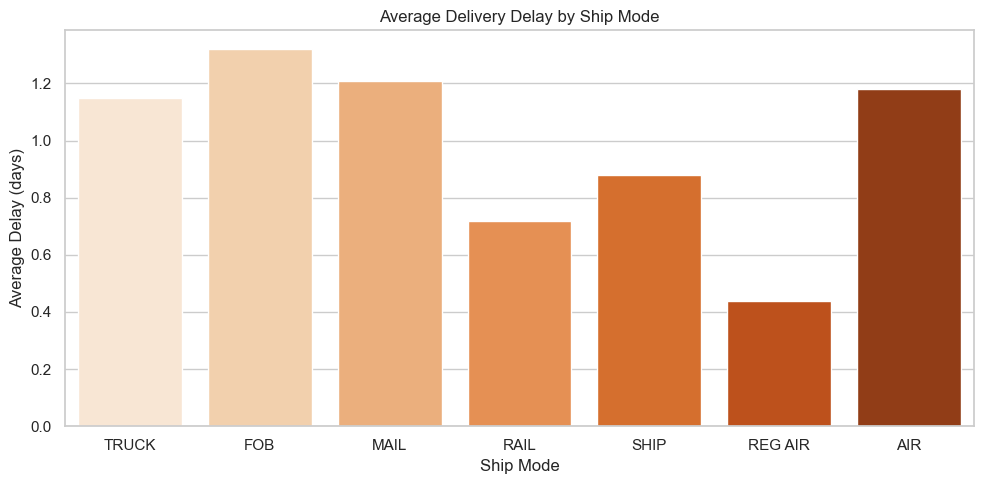

In [12]:

query = """
SELECT
    l_shipmode AS ship_mode,
    COUNT(*) FILTER (WHERE julianday(l_shipdate) > julianday(l_commitdate)) AS delayed_count,
    ROUND(AVG(julianday(l_shipdate) - julianday(l_commitdate)), 2) AS avg_delay_days
FROM
    lineitem
GROUP BY
    l_shipmode
ORDER BY
    delayed_count DESC;
"""

delay_df = run_sql_query(db_file, query)

# Save for further analysis in excel and bi
delay_df.to_csv("delivery_delay_analysis.csv", index=False)


# Plot: Average delay in days
plt.figure(figsize=(10, 5))
sns.barplot(x="ship_mode", y="avg_delay_days", data=delay_df, palette="Oranges")
plt.title("Average Delivery Delay by Ship Mode")
plt.xlabel("Ship Mode")
plt.ylabel("Average Delay (days)")
plt.tight_layout()
plt.show()




### All forms of shipping maintained relatively low shipment delays, however RAIL, SHIP and REG AIR are potentially much more reliable shipment options, especially considering each ship method has similar revenue 

# Top supplier by revenue per region


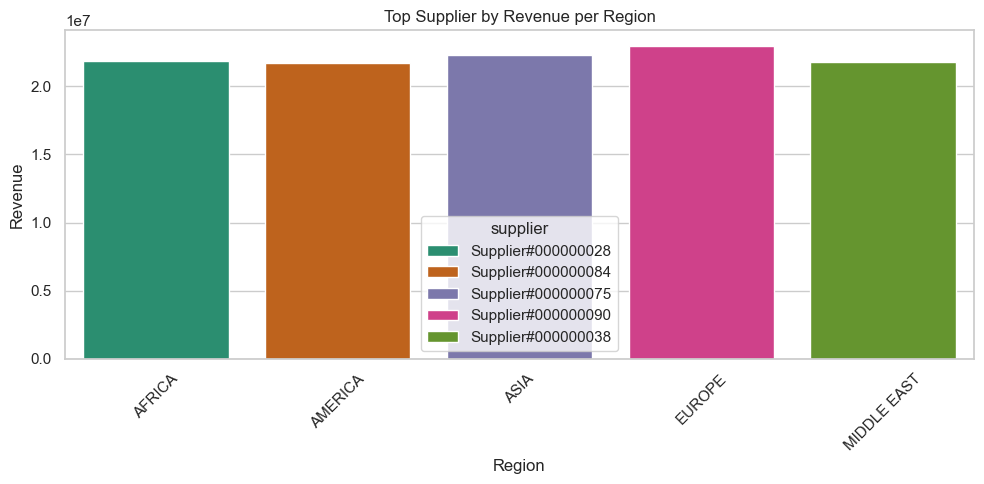

In [13]:
query = """
WITH supplier_revenue AS (
    SELECT
        r.r_name AS region,
        s.s_name AS supplier,
        ROUND(SUM(l.l_extendedprice * (1 - l.l_discount)), 2) AS revenue
    FROM
        region r
    JOIN
        nation n ON r.r_regionkey = n.n_regionkey
    JOIN
        supplier s ON n.n_nationkey = s.s_nationkey
    JOIN
        lineitem l ON s.s_suppkey = l.l_suppkey
    JOIN
        orders o ON l.l_orderkey = o.o_orderkey
    GROUP BY
        region, supplier
),
ranked_suppliers AS (
    SELECT *,
           RANK() OVER (PARTITION BY region ORDER BY revenue DESC) AS rank
    FROM supplier_revenue
)
SELECT *
FROM ranked_suppliers
WHERE rank = 1
ORDER BY region;
"""

top_suppliers_df = run_sql_query(db_file, query)

# Save for further analysis in excel and bi
top_suppliers_df.to_csv("top_suppliers.csv", index=False)

# Plot revenue per top supplier by region
plt.figure(figsize=(10, 5))
sns.barplot(x="region", y="revenue", hue="supplier", data=top_suppliers_df, palette="Dark2")
plt.title("Top Supplier by Revenue per Region")
plt.xlabel("Region")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
